# Decision Tree part

# data loading and splitting

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load and clean data
df = pd.read_csv("heart.csv")
df.columns = df.columns.str.strip()

# Identify categorical and numerical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if (df[col].dtype in ['int64', 'float64']) 
          and (col != "HeartDisease")]

# Split data into features (X) and target (Y)
X = df.drop("HeartDisease", axis=1)
Y = df["HeartDisease"]

# Split into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.30, stratify=Y, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

# Reset indices to ensure alignment between features and labels
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Initialize encoders/scalers
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
scaler = StandardScaler()

# Process training data
x_train_cat = ohe.fit_transform(x_train[cat_col])
x_train_num = scaler.fit_transform(x_train[num_col])
x_train_processed = np.hstack([x_train_num, x_train_cat])

# Process validation/test data
x_val_cat = ohe.transform(x_val[cat_col])
x_val_num = scaler.transform(x_val[num_col])
x_val_processed = np.hstack([x_val_num, x_val_cat])

x_test_cat = ohe.transform(x_test[cat_col])
x_test_num = scaler.transform(x_test[num_col])
x_test_processed = np.hstack([x_test_num, x_test_cat])

# Get feature names
num_feature_names = num_col
cat_feature_names = ohe.get_feature_names_out(cat_col)
all_feature_names = num_feature_names + list(cat_feature_names)

# Create DataFrames with reset indices
x_train = pd.DataFrame(x_train_processed, columns=all_feature_names)
x_val = pd.DataFrame(x_val_processed, columns=all_feature_names)
x_test = pd.DataFrame(x_test_processed, columns=all_feature_names)

print(f"Training Set: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

Training Set: (642, 20), Validation: (92, 20), Test: (184, 20)


# different depths to try with 

In [2]:

#min depth of a full binary tree log2(918)=10 , the best depth is around this value
valid_depths=[4,5,6,7,8,9,10,11,12,13,14,15,16]
trained_trees={}   # map from depth to training node


# Node class

In [5]:
import math
import random

class TrainingNode:
    def __init__(self, x_train, y_train, current_depth=0, label=None):
        self.x_train = x_train
        self.y_train = y_train
        self.current_depth = current_depth
        self.label = label
        self.split_feature = None
        self.split_value = None
        self.children = {}

    def compute_entropy(self, y):
        if len(y) == 0:
            return 0
        proportions = y.value_counts(normalize=True)
        return -sum(p * math.log2(p) for p in proportions if p > 0)

    def majority_label(self):
        if len(self.y_train) == 0:
            return self.label
        return self.y_train.mode()[0]

    def best_split(self):
        base_entropy = self.compute_entropy(self.y_train)
        best_gain = 0
        best_feature = None
        best_value = None
        
        for feature in self.x_train.columns:
            values = self.x_train[feature]
            
            if pd.api.types.is_numeric_dtype(values):
                sorted_vals = sorted(values.unique())
                for i in range(len(sorted_vals) - 1):
                    threshold = (sorted_vals[i] + sorted_vals[i+1]) / 2
                    left_mask = values <= threshold
                    right_mask = values > threshold

                    # Calculate entropy for left and right
                    left_entropy = self.compute_entropy(self.y_train[left_mask])
                    right_entropy = self.compute_entropy(self.y_train[right_mask])

                    weighted_entropy = (
                        left_mask.sum() * left_entropy
                        + right_mask.sum() * right_entropy
                    ) / len(self.y_train)

                    gain = base_entropy - weighted_entropy
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_value = threshold
        
        return best_feature, best_value, best_gain

    def expand_node(self, max_depth, parent_label=None):
        # 1) If node has no samples, set label to parent's majority
        if self.x_train.shape[0] == 0:
            self.label = parent_label
            return
        
        # 2) Stop if max depth reached or node is pure
        if self.current_depth >= max_depth or self.compute_entropy(self.y_train) == 0:
            self.label = self.majority_label()
            return
        
        # 3) Find best split 
        best_feature, best_value, gain = self.best_split()

        if best_feature is None:
            best_feature = random.choice(list(self.x_train.columns))
            values = self.x_train[best_feature]
            if pd.api.types.is_numeric_dtype(values):
                min_val = values.min()
                max_val = values.max()
                best_value = random.uniform(min_val, max_val)
            else:
                best_value = 0.5
        
        self.split_feature = best_feature
        self.split_value = best_value

        # Create left and right children
        left_mask = self.x_train[best_feature] <= best_value
        right_mask = ~left_mask

        # Left Child
        left_x = self.x_train[left_mask]
        left_y = self.y_train[left_mask]
        self.children['left'] = TrainingNode(left_x, left_y, self.current_depth + 1)
        self.children['left'].expand_node(max_depth, parent_label=self.majority_label())

        # Right Child
        right_x = self.x_train[right_mask]
        right_y = self.y_train[right_mask]
        self.children['right'] = TrainingNode(right_x, right_y, self.current_depth + 1)
        self.children['right'].expand_node(max_depth, parent_label=self.majority_label())

    def predict_one(self, x):
        if self.split_feature is None or len(self.children) == 0:
            return self.label
        
        if x[self.split_feature] <= self.split_value:
            return self.children['left'].predict_one(x)
        else:
            return self.children['right'].predict_one(x)

    def predict(self, X):
        return [self.predict_one(row) for _, row in X.iterrows()]

# training at different levels

In [6]:
# train at different levels

for depth in valid_depths:
    root = TrainingNode(x_train, y_train, current_depth=0)
    root.expand_node(max_depth=depth)
    trained_trees[depth] = root

# choosing best depth

In [7]:
# evaluation using validation set (determine best depth without overfitting)
from sklearn.metrics import accuracy_score
def evaluate_tree(tree, x_val, y_val):
    predictions = tree.predict(x_val)
    return accuracy_score(y_val, predictions)


best_val_score = 0.0

for depth, tree in trained_trees.items():
    val_score = evaluate_tree(tree, x_val, y_val)
    print(f"Depth={depth}, Validation Accuracy={val_score:.4f}")
    
    if val_score >= best_val_score:
        best_val_score = val_score
        best_depth = depth
        best_tree = tree

print(f"\nBest Depth: {best_depth} with Validation Accuracy: {best_val_score:.4f}")

Depth=4, Validation Accuracy=0.8696
Depth=5, Validation Accuracy=0.8804
Depth=6, Validation Accuracy=0.8370
Depth=7, Validation Accuracy=0.8152
Depth=8, Validation Accuracy=0.7935
Depth=9, Validation Accuracy=0.8043
Depth=10, Validation Accuracy=0.8152
Depth=11, Validation Accuracy=0.8261
Depth=12, Validation Accuracy=0.8152
Depth=13, Validation Accuracy=0.8152
Depth=14, Validation Accuracy=0.8152
Depth=15, Validation Accuracy=0.8152
Depth=16, Validation Accuracy=0.8152

Best Depth: 5 with Validation Accuracy: 0.8804


# Results and Evaluation

Test Accuracy: 0.8315
Test F1 Score: 0.8426


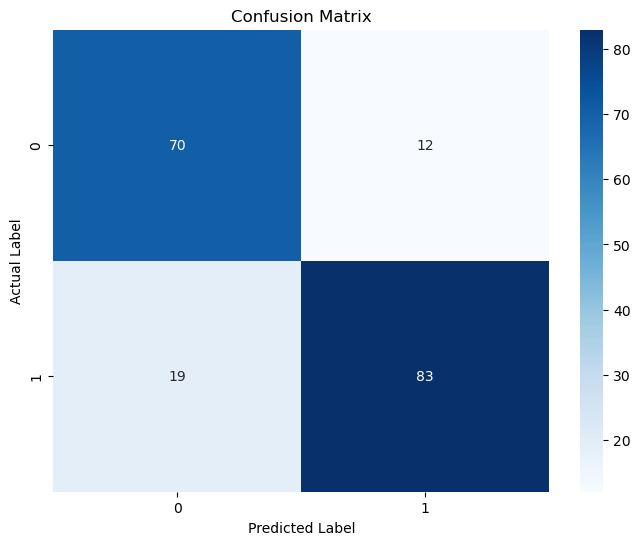

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

test_predictions = best_tree.predict(x_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)

# Output the accuracy and F1 score
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix as a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


# Neural netwok part

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Define hyperparameter values to tune and choose best one
learning_rates = [0.001, 0.0001]         # 0.01 get very harsh curves
hidden_neurons = [16, 32]

# Track the best model
best_val_acc = 0
best_model = None
best_hyperparams = None
best_history = None 

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for lr in learning_rates:
    for neurons in hidden_neurons:
        print(f"\nTraining model with {neurons} neurons and learning rate {lr}")

        # Dense for fully connected layer and sequential as it goes forward only 
        model = Sequential([
            Dense(neurons, activation='relu', input_shape=(x_train.shape[1],)),
            Dense(1, activation='sigmoid')
        ])

        # Adam is an optimizer using stochastic gradient descent and optimizing learing rate for different parameters
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Train model
        history = model.fit(x_train, y_train, 
                            epochs=100, batch_size=32, 
                            validation_data=(x_val, y_val), 
                            callbacks=[early_stopping], verbose=0)
        
        # Evaluate on validation set
        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save best model and history based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_hyperparams = (neurons, lr)
            best_history = history  

# Print best model configuration
best_neurons, best_lr = best_hyperparams
print(f"\nBest model: {best_neurons} neurons with learning rate {best_lr}")

# Evaluate best model on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy for best model ({best_neurons} neurons, LR={best_lr}): {test_acc:.4f}")

# Generate Predictions
y_pred_probs = best_model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)  # get label from probability 

# Compute F1 Score
f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot training history for the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


ModuleNotFoundError: No module named 'tensorflow'

# Bagging

In [10]:
from sklearn.utils import resample
from collections import Counter

class BaggingClassifier:
    def __init__(self, n_estimators=20):
        self.n_estimators = n_estimators
        self.estimators = []
    
    def fit(self, x, y):
        self.estimators = []
        for _ in range(self.n_estimators):
            x_sample, y_sample = resample(x, y, random_state=42)
            estimator = TrainingNode(x_sample, y_sample, current_depth=0)
            estimator.expand_node(max_depth=5)
            self.estimators.append(estimator)
    
    def predict(self, x):
        predictions = np.array([estimator.predict(x) for estimator in self.estimators])
        # Majority vote
        final_predictions = []
        for i in range(x.shape[0]):
            vote = Counter(predictions[:, i])
            final_predictions.append(vote.most_common(1)[0][0])
        return np.array(final_predictions)


## Training

In [11]:
model = BaggingClassifier()
model.fit(x_train, y_train)


# Results and Evaluation

Test Accuracy: 0.8152
Test F1 Score: 0.8283


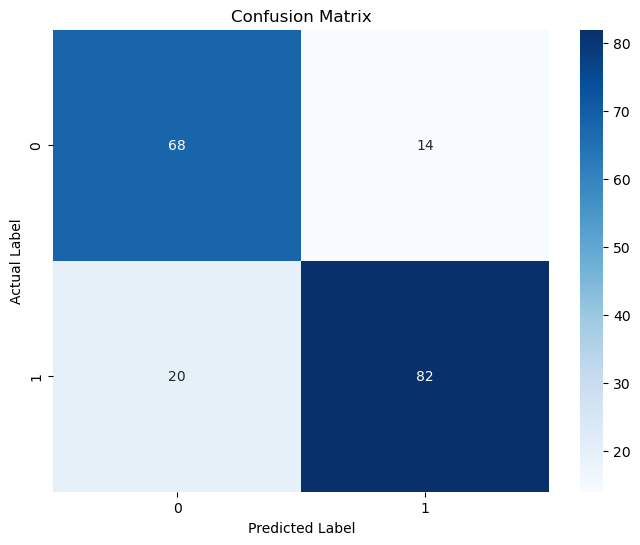

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


y_pred = model.predict(x_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the accuracy and F1 score
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix as a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

Test Accuracy: 0.8750
Test F1 Score: 0.8889


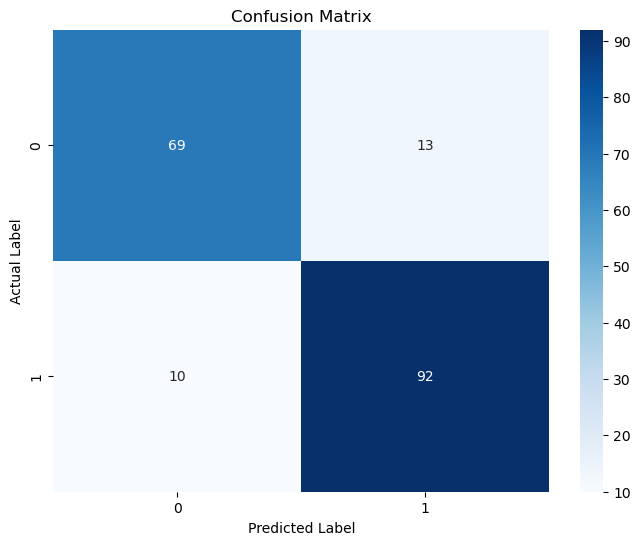

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=100, random_state=42)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Output the accuracy and F1 score
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix as a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Stump class

In [13]:
class Stump:
    def __init__(self):
        self.best_split = None
        self.best_threshold = None
        self.classification_direction = 1
        self.min_error = float("inf")
        self.weight = None
    
    def misclassification_error(self, y, predictions, sample_weights):
        return np.sum(sample_weights[predictions != y])
    
    def change_min_error(self, error, feature, threshold, direction):
        self.min_error = error
        self.best_split = feature
        self.best_threshold = threshold
        self.classification_direction = direction

    def fit(self, x, y, sample_weights):
        num_samples, num_features = x.shape

        # iterate over all features and all possible thresholds to find the best decision stump
        for feature in range(num_features):
            feature_values = np.unique(x[:, feature])
            for threshold in feature_values:
                for direction in [0, 1]:
                    predictions = np.ones(num_samples)
                    if direction == 1:
                        predictions[x[:, feature] < threshold] = 0
                    else:
                        predictions[x[:, feature] > threshold] = 0

                    error = self.misclassification_error(y, predictions, sample_weights)

                    if error < self.min_error:
                        self.change_min_error(error, feature, threshold, direction)
                        

    def predict(self, x):
        N = x.shape[0]
        predictions = np.ones(N)
        if self.classification_direction == 1:
            for i in range(N):
                if x[i, self.best_split] < self.best_threshold:
                    predictions[i] = 0
        else:
            for i in range(N):
                if x[i, self.best_split] > self.best_threshold:
                    predictions[i] = 0

        return predictions

# Adaboost Class

In [14]:
class Adaboost:
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
        self.weights = []
        self.stumps = []

    def train(self, x, y):
        num_samples = x.shape[0]
        sample_weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_iterations):
            stump = Stump()
            stump.fit(x, y, sample_weights)
            predictions = stump.predict(x)

            error = np.sum(sample_weights[predictions != y]) / np.sum(sample_weights)

            if error > 0.5:
                print("Error is greater than 0.5, stopping training because it's worse than random guessing")
                break

            weight = 0.5 * np.log((1 - error) / error)
            stump.weight = weight

            sample_weights *= np.exp(-weight * (2 * y - 1) * (2 * predictions - 1))
            sample_weights /= np.sum(sample_weights)

            self.stumps.append(stump)
            self.weights.append(weight)

    def predict(self, x):
        num_samples = x.shape[0]
        final_predictions = np.zeros(num_samples)

        for stump, weight in zip(self.stumps, self.weights):
            final_predictions += weight * stump.predict(x)

        return (final_predictions >= (0.5 * sum(self.weights))).astype(int)

# Training the Model

In [15]:
adaboost = Adaboost(num_iterations=50)
adaboost.train(x_train.values, y_train.values)
prediction_train = adaboost.predict(x_train.values)
prediction_val = adaboost.predict(x_val.values)
prediction_test = adaboost.predict(x_test.values)

# Results and Evaluation

Test Accuracy: 0.8641
Test F1 Score: 0.8731


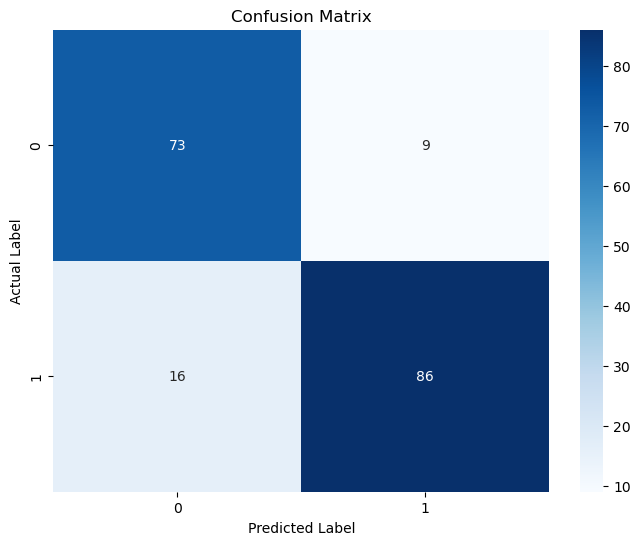

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

accuracy = accuracy_score(y_test, prediction_test)
f1 = f1_score(y_test, prediction_test)
conf_matrix = confusion_matrix(y_test, prediction_test)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# KNN - Training Data on Arbitrary K

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

train_score = knn.score(x_train, y_train)
val_score = knn.score(x_val, y_val)
test_score = knn.score(x_test, y_test)

print(f"Train Score: {train_score:.4f}")
print(f"Validation Score: {val_score:.4f}")
print(f"Test Score: {test_score:.4f}")

Train Score: 0.8754
Validation Score: 0.8913
Test Score: 0.8750


c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

# Tune Hyperparameters

In [18]:
models = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    models.append(knn)

val_scores = [model.score(x_val, y_val) for model in models]
best_k = np.argmax(val_scores) + 1
print(f"Best k: {best_k}")

Best k: 11


c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

# Train on K = 11


In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train, y_train)

train_score = knn.score(x_train, y_train)
val_score = knn.score(x_val, y_val)
test_score = knn.score(x_test, y_test)

print(f"Train Score: {train_score:.4f}")
print(f"Validation Score: {val_score:.4f}")
print(f"Test Score: {test_score:.4f}")

Train Score: 0.8707
Validation Score: 0.9348
Test Score: 0.8859


c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

# Results and Evaluation

c:\Users\M\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test Accuracy: 0.8859
Test F1 Score: 0.8986


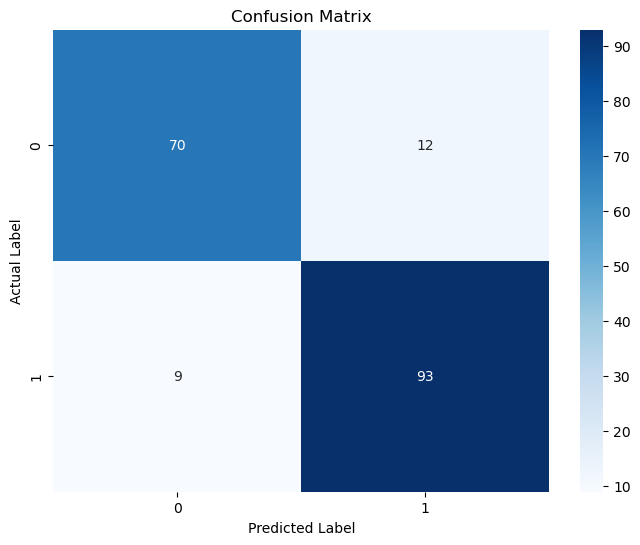

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

prediction_test = knn.predict(x_test)
accuracy = accuracy_score(y_test, prediction_test)
f1 = f1_score(y_test, prediction_test)
conf_matrix = confusion_matrix(y_test, prediction_test)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()